# Advanced Lane Finding


The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Frist step camera calibration
---

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6 * 9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store[存储] object points and image points from all the images.
objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane[平面].

# Make a list of calibration images
images = glob.glob('camera_cal/ca*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # If found, add object points, image points
    if not ret != True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        # write_name = 'corners_found'+str(idx)+'.jpg'
        # cv2.imwrite(write_name, img)
#         plt.imshow(img)
#         plt.show()

### Save the camera calibration result for later use

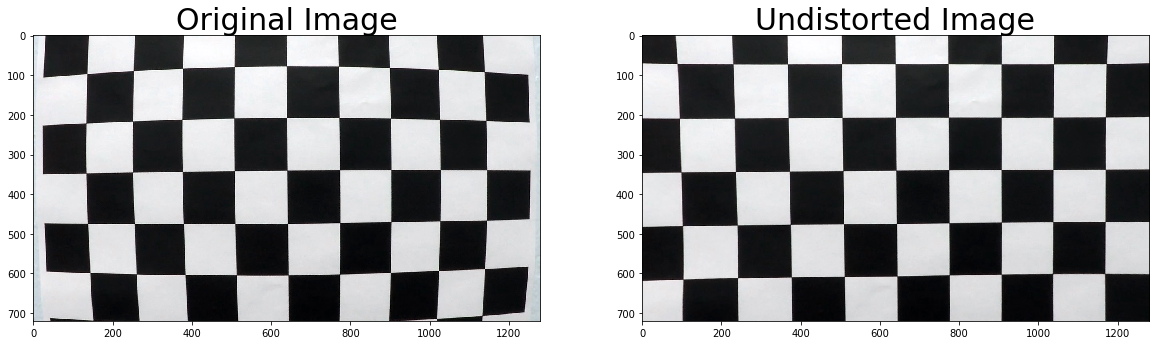

In [2]:
import pickle

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/undistortion.jpg', dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {"mtx": mtx, "dist": dist}
pickle.dump(dist_pickle, open("camera_cal/wide_dist_pickle.p", "wb"))
# dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

## Load pickle file then apply a distortion correction and warp to raw images.

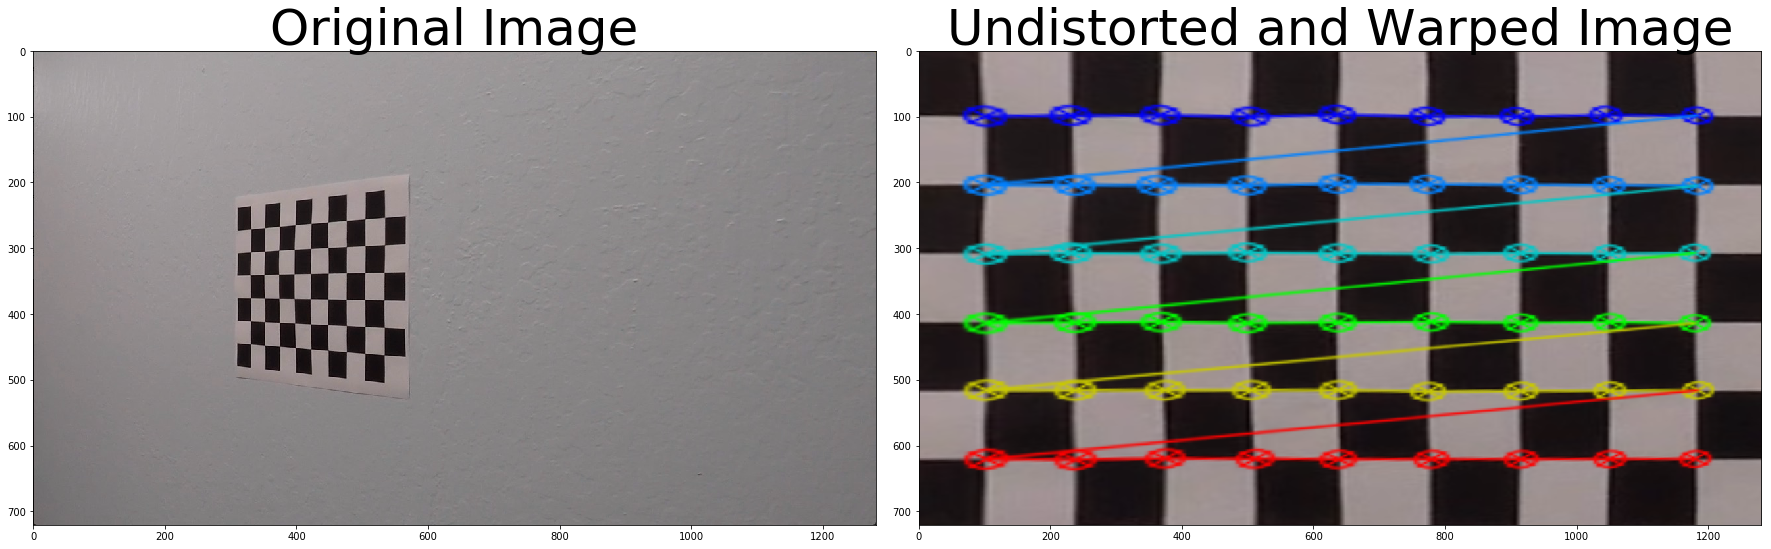

In [3]:
import matplotlib.image as mpimg

dist_pickle = pickle.load(open("camera_cal/wide_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('camera_cal/calibration7.jpg')
nx = 9  # the number of inside corners in x
ny = 6  # the number of inside corners in y

def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset],
                                     [img_size[0]-offset, img_size[1]-offset],
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return (warped, M)

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

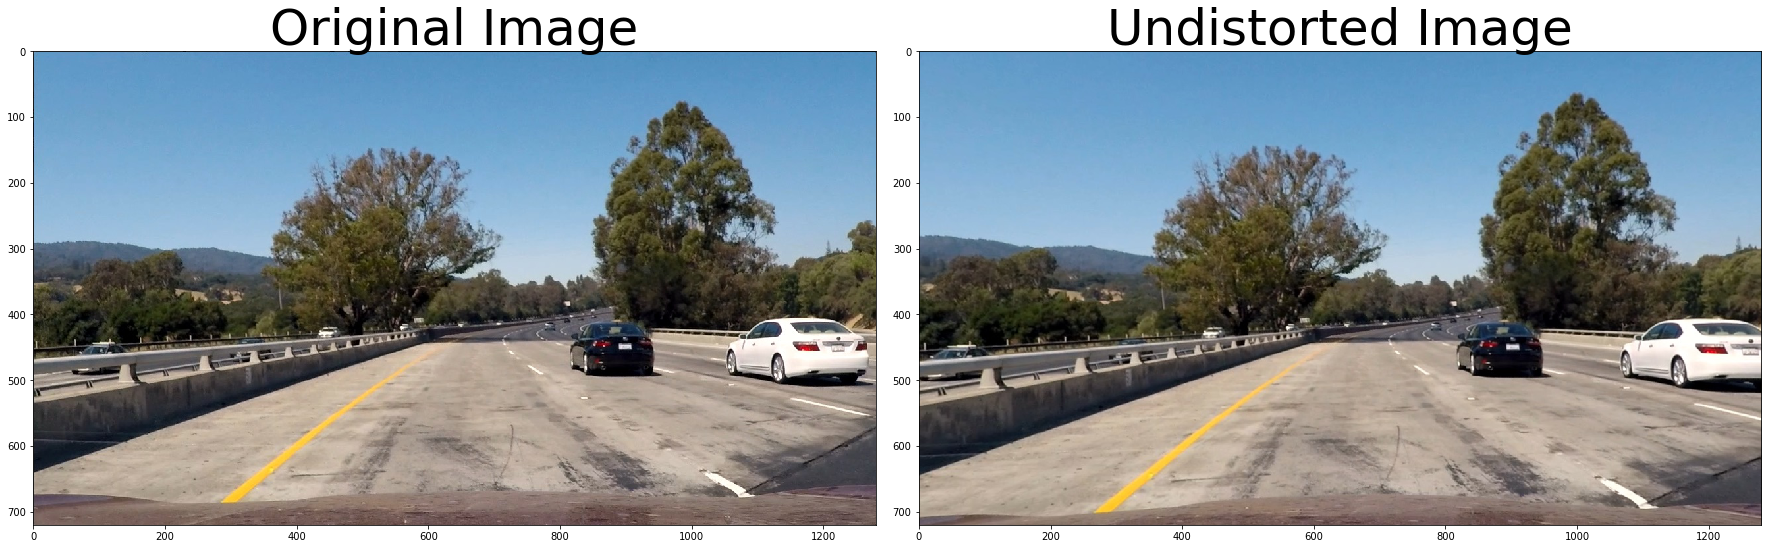

In [4]:
test_img = plt.imread('test_images/test1.jpg')
test_undist = cv2.undistort(test_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## creat a  binary image using color transforms, gradients
---

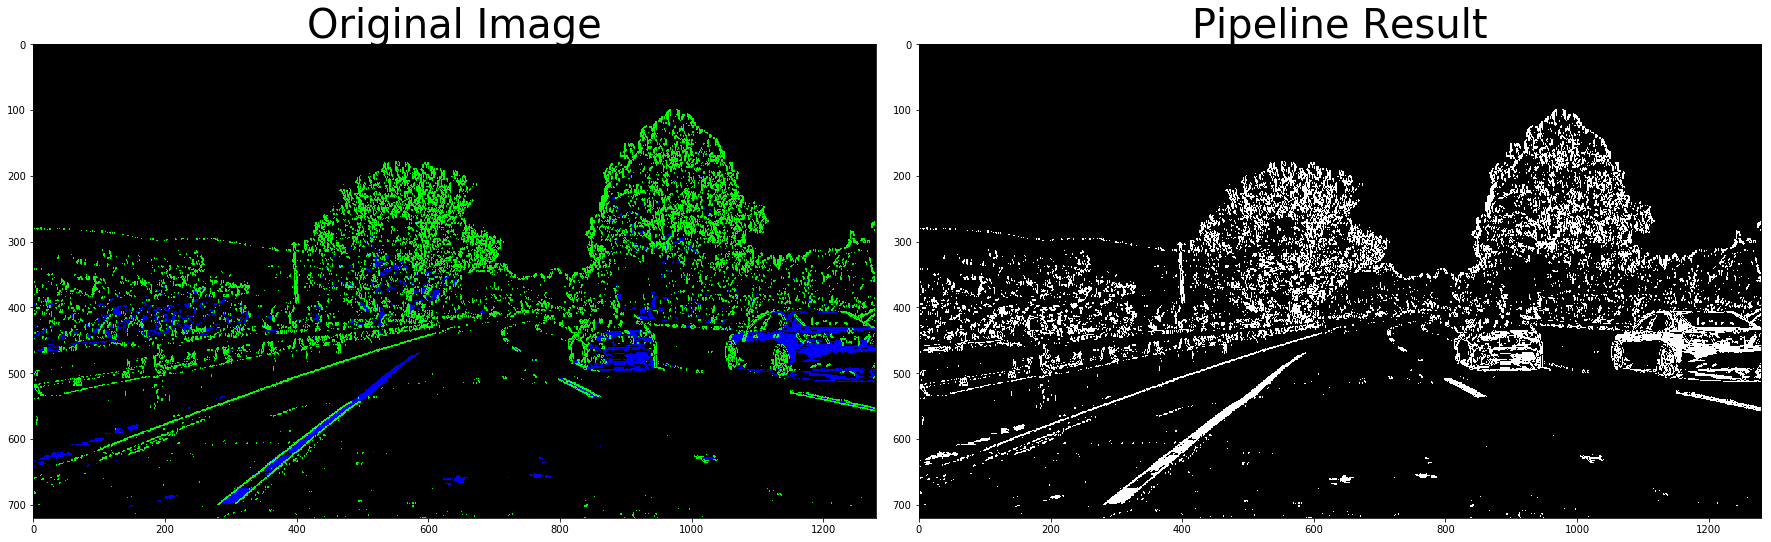

In [5]:
test_img = plt.imread('test_images/test4.jpg')
test_undist = cv2.undistort(test_img, mtx, dist, None, mtx)

# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary,combined_binary

color_binary, combined_binary = pipeline(test_undist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(color_binary)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(combined_binary,cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply a perspective transform to rectify binary image  ("birds-eye view")

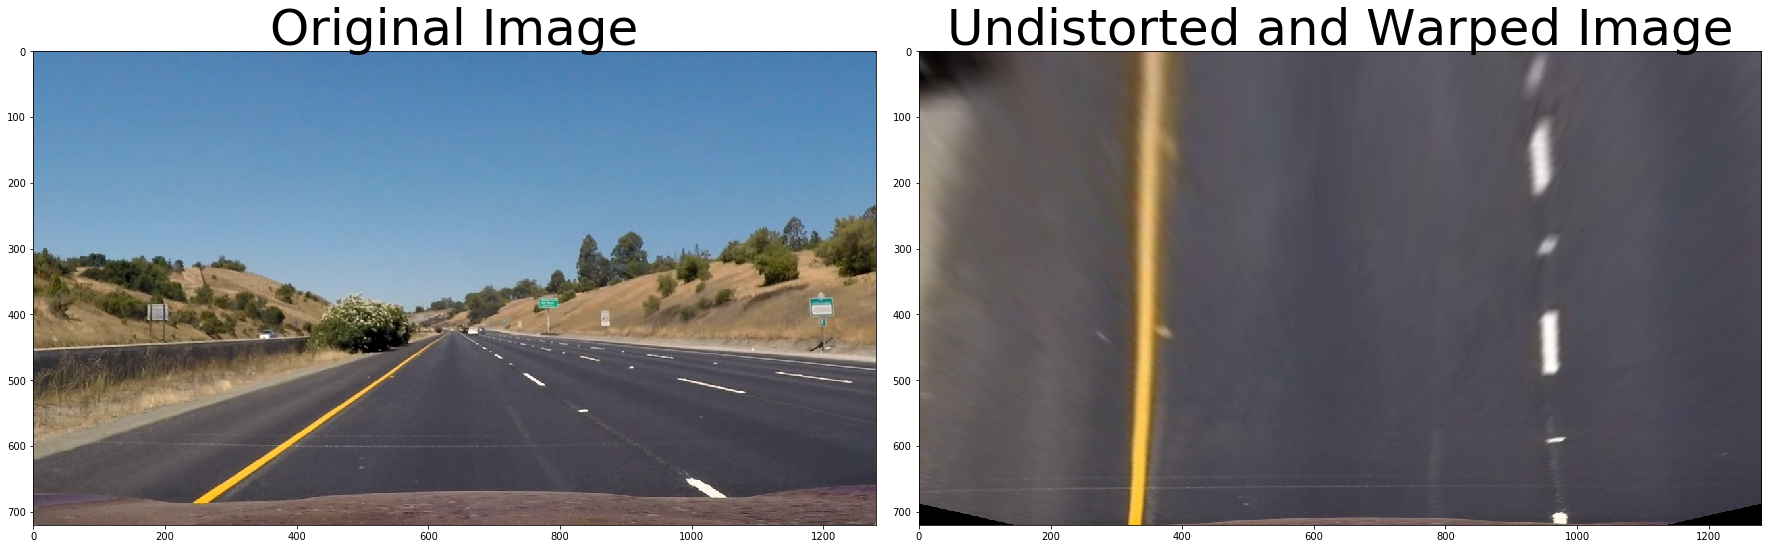

In [6]:
def birds_eye(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
    img_size = (gray.shape[1], gray.shape[0])
    
    src = np.float32([[590,450],[225,700],[1055,700],[690,450]])
    dst = np.float32([[320,-100],[320,720],[960,720],[960,-100]])

    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    
    return (warped, M)

test_img = plt.imread('test_images/straight_lines1.jpg')

top_down, perspective_M = birds_eye(test_img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

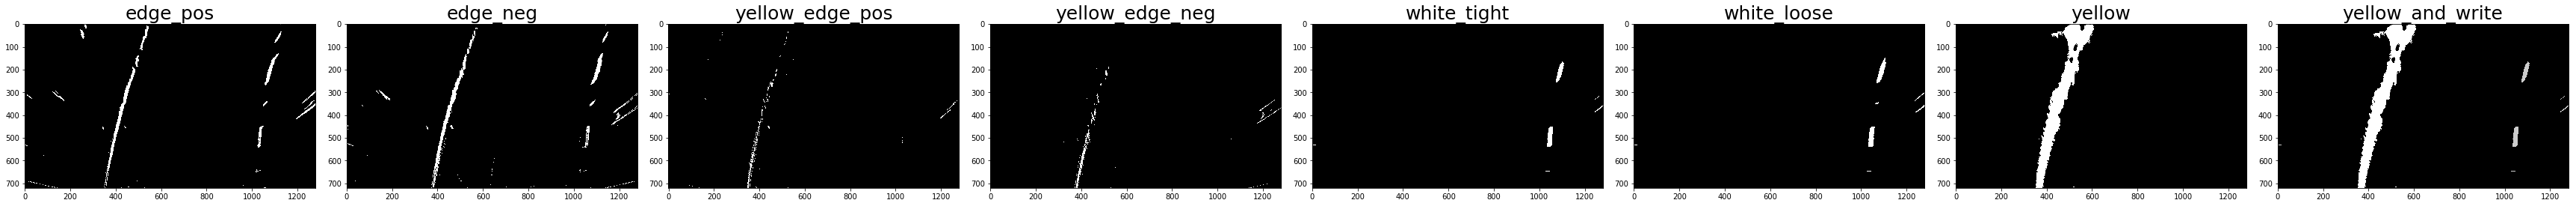

In [7]:
def split_channels(img) :
        """
        returns a total of 7 channels : 
        4 edge channels : all color edges (including the signs), yellow edges (including the signs) 
        3 color channels : yellow and white (2 different thresholds are used for white) 
        """
        binary = {}  
        
        # thresholding parameters for various color channels and Sobel x-gradients
        h_thresh=(15, 35)
        s_thresh=(75, 255) #s_thresh=(30, 255)
        v_thresh=(175,255)
        vx_thresh = (20, 120)
        sx_thresh=(10, 100)

        img = np.copy(img)
        # Convert to HSV color space and separate the V channel
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
        h_channel = hsv[:,:,0]
        s_channel = hsv[:,:,1]
        v_channel = hsv[:,:,2]

        # Sobel x for v-channel
        sobelx_pos = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0, ksize=3) # Take the derivative in x
        sobelx_neg = np.copy(sobelx_pos)
        sobelx_pos[sobelx_pos<=0] = 0
        sobelx_neg[sobelx_neg>0] = 0
        sobelx_neg = np.absolute(sobelx_neg)
        scaled_sobel_pos = np.uint8(255*sobelx_pos/np.max(sobelx_pos))
        scaled_sobel_neg = np.uint8(255*sobelx_neg/np.max(sobelx_neg))
        vxbinary_pos = np.zeros_like(v_channel)
        vxbinary_pos[(scaled_sobel_pos >= vx_thresh[0]) & (scaled_sobel_pos <= vx_thresh[1])] = 1
        binary['edge_pos'] = vxbinary_pos
        vxbinary_neg = np.zeros_like(v_channel)
        vxbinary_neg[(scaled_sobel_neg >= vx_thresh[0]) & (scaled_sobel_neg <= vx_thresh[1])] = 1
        binary['edge_neg'] = vxbinary_neg

        # Sobel x for s-channel
        sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=3) # Take the derivative in x
        sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*sobelx/np.max(sobelx))
        sxbinary_pos = np.zeros_like(s_channel)
        sxbinary_neg = np.zeros_like(s_channel)
        sxbinary_pos[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]) 
                     & (scaled_sobel_pos >= vx_thresh[0]-10) & (scaled_sobel_pos <= vx_thresh[1])]=1
        sxbinary_neg[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]) 
                     & (scaled_sobel_neg >= vx_thresh[0]-10) & (scaled_sobel_neg <= vx_thresh[1])]=1           
        binary['yellow_edge_pos'] = sxbinary_pos
        binary['yellow_edge_neg'] = sxbinary_neg

        # color thresholds for selecting white lines
        v_binary = np.zeros_like(v_channel)
        v_binary[(v_channel >= v_thresh[0]+s_channel+20) & (v_channel <= v_thresh[1])] = 1
        binary['white_tight'] = np.copy(v_binary)
        v_binary[v_channel >= v_thresh[0]+s_channel] = 1
        binary['white_loose'] = v_binary

        # color threshold for selecting yellow lines
        h_binary = np.zeros_like(h_channel)
        h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1]) & (s_channel >= s_thresh[0])] = 1
        binary['yellow'] = h_binary
        binary['yellow_and_write'] = cv2.addWeighted(binary['white_tight'], 0.8, binary['yellow'], 1, 0.)
        return binary

def plot_images(imgs, titles, cmap='gray', figsize=(48, 18)):
    nimgs = len(imgs)
    f, axes = plt.subplots(1, nimgs, figsize=figsize)
    f.tight_layout()
    i=0
    for a in axes:
#         print(imgs[i],titles[i])
        a.imshow(imgs[i], cmap=cmap)
        a.set_title(titles[i], fontsize=25)
        i+=1

test_img = plt.imread('test_images/test6.jpg')

top_down, perspective_M = birds_eye(test_img, mtx, dist)

binary = split_channels(top_down)
titles=tuple(binary.keys())
imgs=tuple(binary.values())
plot_images(imgs,titles)

## Detect lane pixels and fit to find the lane boundary

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


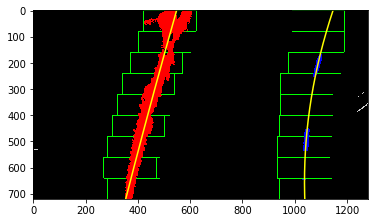

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


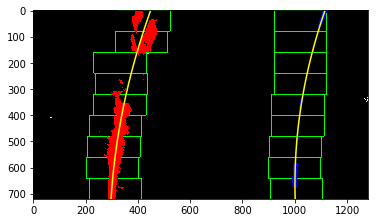

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


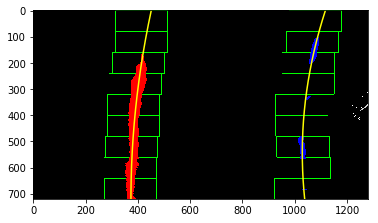

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


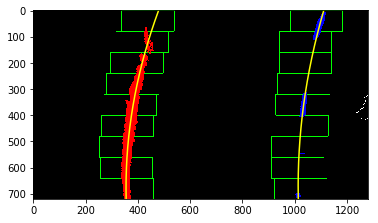

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


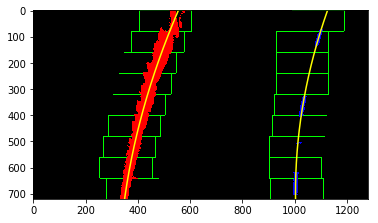

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


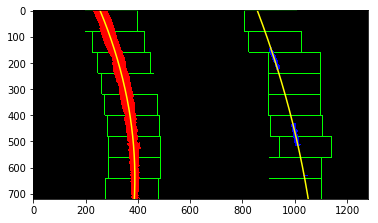

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


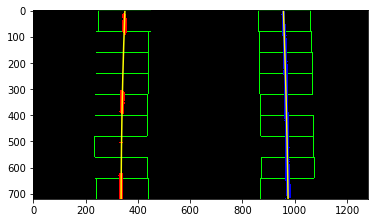

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


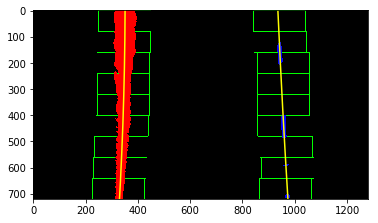

In [8]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img

def img_fit(img):
    top_down, perspective_M = birds_eye(img, mtx, dist)
    binary = split_channels(top_down)
    out_img = fit_polynomial(binary['yellow_and_write'])
    
    return out_img

def show_images_list(images, cmap=None):
    cols = 2
    rows = (len(images)+1) //cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)  
        cmap = 'gray' if len(image.shape)==2 else cmap # use gray scale color map if there is only one channel
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    
import glob

test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]

for i in range(len(test_images)):
    plt.imshow(img_fit(test_images[i]))
    plt.show()
# show_images_list(list(map(lambda image:img_fit(image),test_images)))

# imgs_fit = list(map(lambda image:img_fit(image),test_images))

# plot_images(imgs_fit,list(range(len(test_images))))

## Determine the curvature of the lane

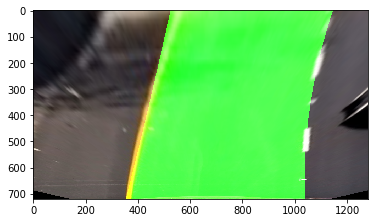

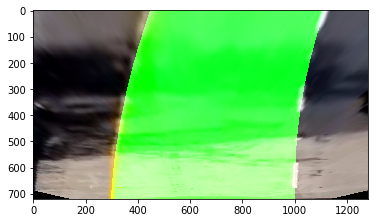

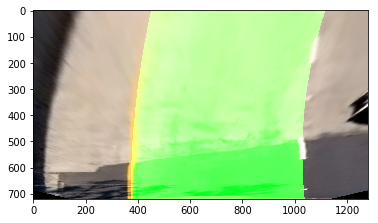

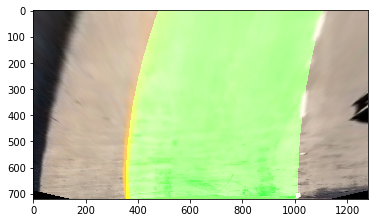

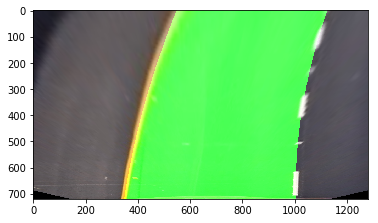

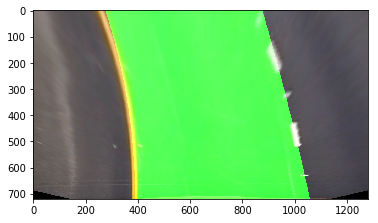

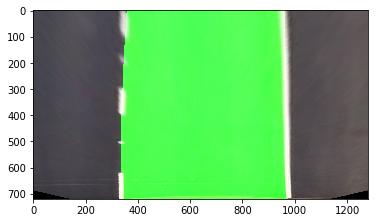

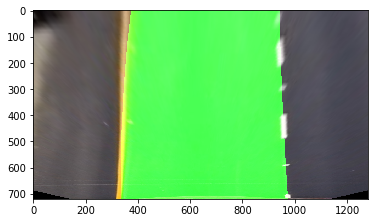

In [9]:
from PIL import Image

left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def lanes_to_wmask(wimg, x1, y1, x2, y2):
    """Generate the lane mask using left and right lanes.
    """
    shape = wimg.shape[0:2]

    # Create an image to draw the lines on
    warp_zero = np.zeros(shape, np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([y1, x1]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([y2, x2])))])
    pts = np.hstack((pts_left, pts_right))
    pts = np.array([pts], dtype=np.int64)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, pts, (0, 255, 0))
    return color_warp

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    
    left_line_window = np.array([np.flipud(np.transpose(np.vstack([left_fitx, 
                              ploty])))])
    right_line_window = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    middle_line_pts = np.hstack((left_line_window,right_line_window))
#     ax = plt.gca()
#     ax.fill_betweenx(left_fitx,right_fitx,window_img,facecolor="green",color="write")
    cv2.fillPoly(window_img,np.int_([middle_line_pts]) ,(0,255, 0))
#     lanes_to_wmask
    # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.8, 0)
    
    # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    out_image=cv2.resize(window_img, (binary_warped.shape[1], binary_warped.shape[0]), interpolation=cv2.INTER_AREA)
    
    return result,middle_line_pts,left_fitx,right_fitx

def weighted_img(img, initial_img, α=1, β=1., γ=0.):

    return cv2.addWeighted(initial_img, α, img, β, γ)

def img_fit_mask(img):
    top_down, perspective_M = birds_eye(img, mtx, dist)
    binary = split_channels(top_down)
    lane_fill, middle_line_pts, line_left, line_right= search_around_poly(binary['yellow_and_write'])
    lane_mask = np.zeros_like(top_down)
    cv2.fillPoly(lane_mask,np.int_([middle_line_pts]) ,(0,255, 0))
    
    result = weighted_img(top_down, lane_mask)
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
test_images = [mpimg.imread(path) for path in glob.glob('test_images/*.jpg')]

# lane_fill,middle_line_pts=img_fit_mask(test_images[0])
# plt.imshow(test_images[0])
# plt.show()

for i in range(len(test_images)):
    plt.imshow(img_fit_mask(test_images[i]))
    plt.show()

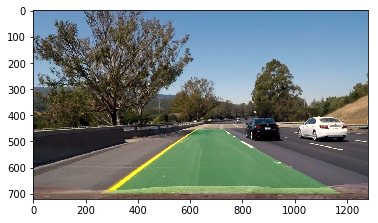

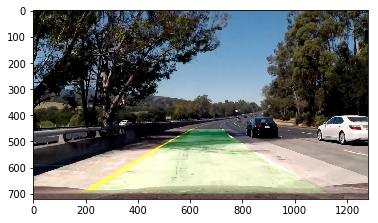

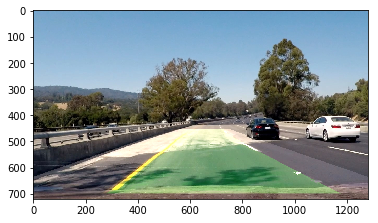

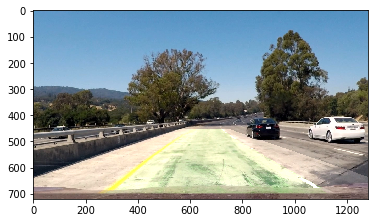

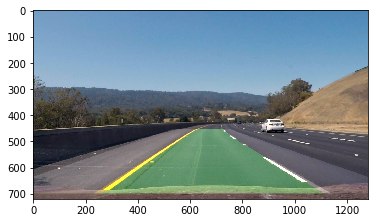

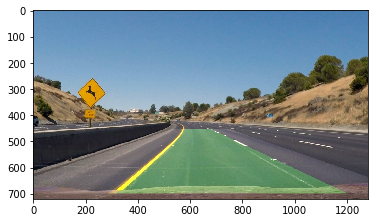

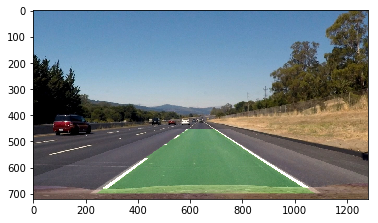

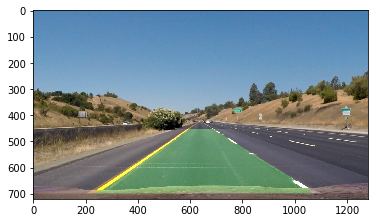

In [10]:
def lane_unwarp(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
    img_size = (gray.shape[1], gray.shape[0])
    
    dst = np.float32([[590,450],[225,700],[1055,700],[690,450]])
    src = np.float32([[320,-100],[320,720],[960,720],[960,-100]])

    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    unwarped = cv2.warpPerspective(undist, M, img_size)
    
    return unwarped 

test_images = [mpimg.imread(path) for path in glob.glob('test_images/*.jpg')]

for i in range(len(test_images)):
    lane_fill = img_fit_mask(test_images[i])
    unwarped = lane_unwarp(lane_fill, mtx, dist)
    result = cv2.addWeighted(test_images[i], 1, np.uint8(unwarped), 0.3, 0)
    plt.imshow(result)
    plt.show()

## vehicle position with respect to center.

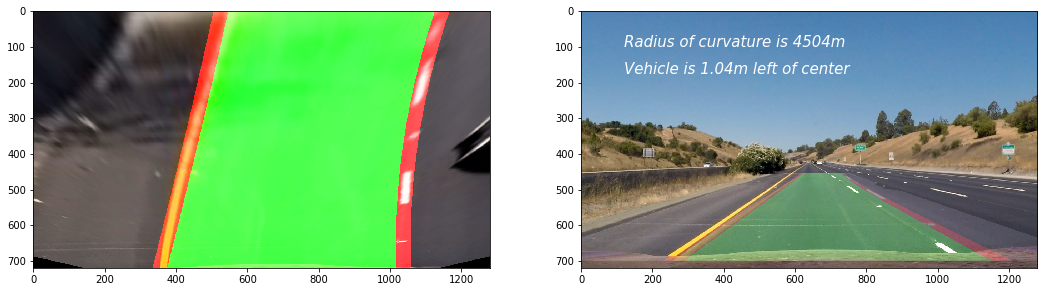

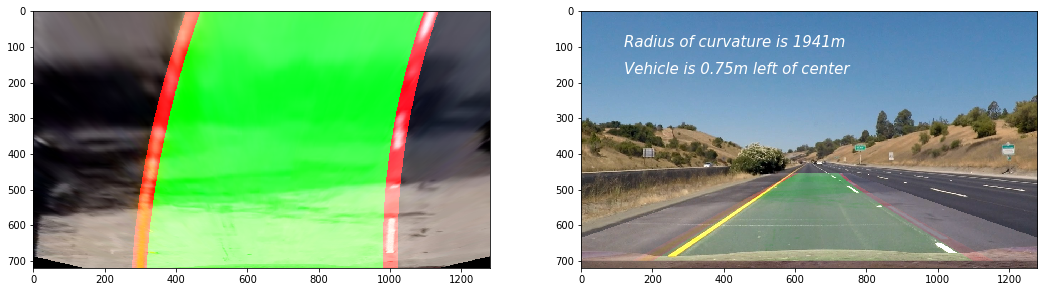

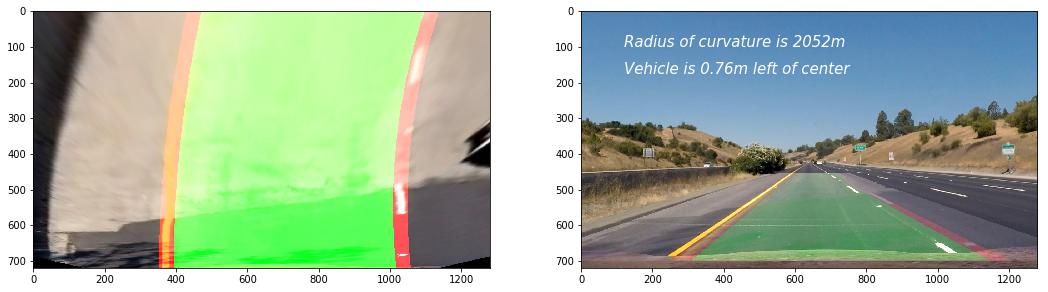

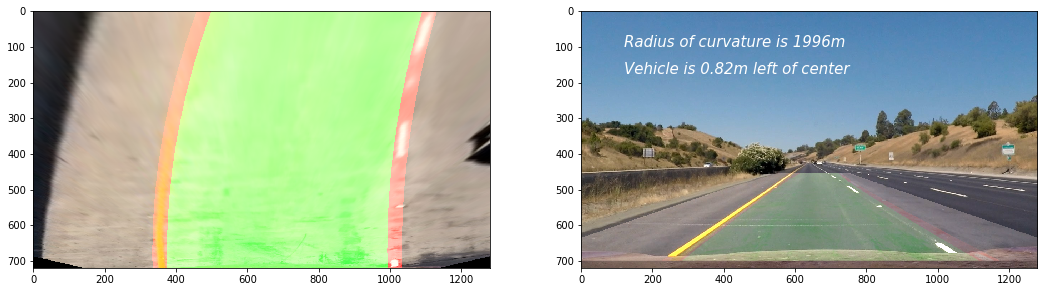

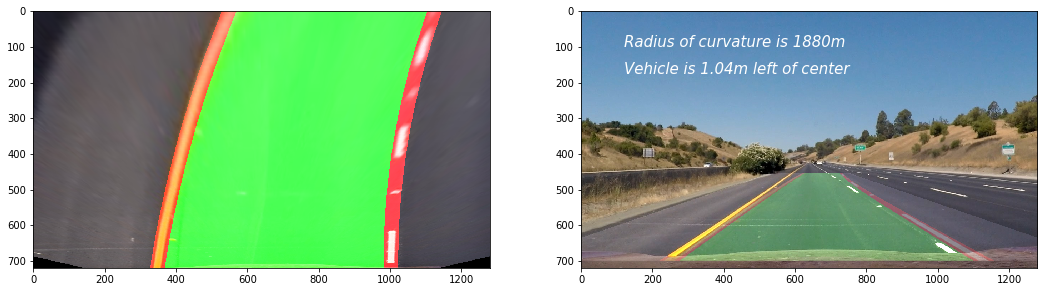

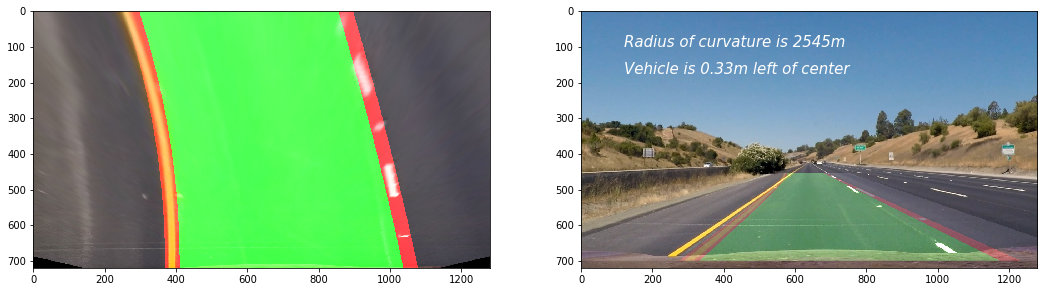

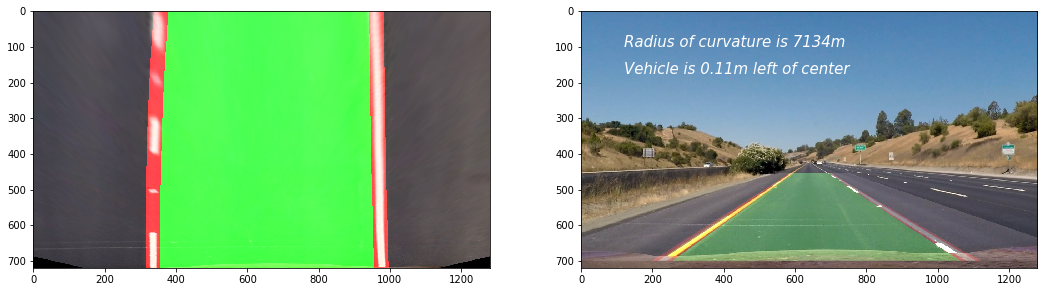

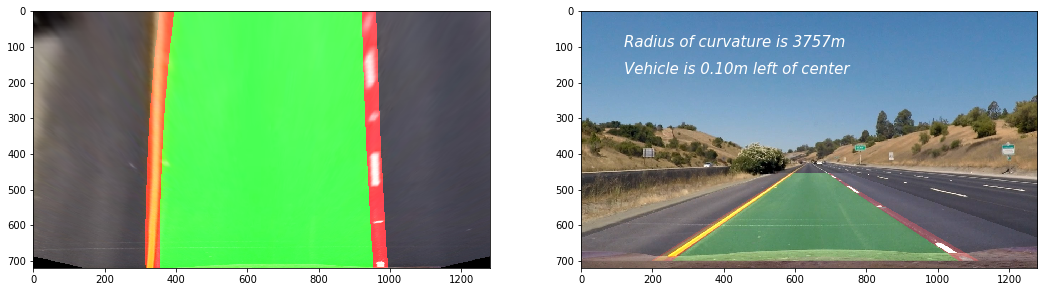

In [30]:
def search_around_poly1(img):
    
    top_down, perspective_M = birds_eye(img, mtx, dist) 
    
    binary = split_channels(top_down)
    
    binary_warped = binary['yellow_and_write']
    
    # Convert undistorted image to grayscale
#     gray = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)
    
    img_size = (binary_warped.shape[1], binary_warped.shape[0])
    
    dst = np.float32([[590,450],[225,700],[1055,700],[690,450]])
    src = np.float32([[320,-100],[320,720],[960,720],[960,-100]])

    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    unwarped = cv2.warpPerspective(binary_warped, M, img_size)
    
    lane_fill = img_fit_mask(test_images[i])
    
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Measure Radius of Curvature for each lane line
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    # Calculate the position of the vehicle
    rightx_int = (right_fitx[0] + right_fitx[1] + right_fitx[2])/3
    leftx_int = (left_fitx[0] + left_fitx[1] + left_fitx[2])/3
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    if center < 640:
        pos = 'Vehicle is {:.2f}m left of center'.format(center*3.7/700)
    else:
        pos = 'Vehicle is {:.2f}m right of center'.format(center*3.7/700)
        
    radius = 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2))
    

    
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin/5, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin/5, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin/5, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin/5, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    left_line_window = np.array([np.flipud(np.transpose(np.vstack([left_fitx, 
                              ploty])))])
    right_line_window = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    middle_line_pts = np.hstack((left_line_window,right_line_window))

    cv2.fillPoly(window_img,np.int_([middle_line_pts]) ,(0,255, 0))
#     lanes_to_wmask
    # Draw the lane onto the warped blank image

    result = cv2.addWeighted(out_img, 1, window_img, 0.8, 0)
    
    # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    lane_mask = np.zeros_like(top_down)
    cv2.fillPoly(lane_mask,np.int_([middle_line_pts]) ,(0,255, 0))
    
    cv2.fillPoly(lane_mask,np.int_([left_line_pts]) ,(255 ,0 , 0))
    cv2.fillPoly(lane_mask,np.int_([right_line_pts]) ,(255 ,0 , 0))
    
    bird_result = weighted_img(top_down, lane_mask)
    
    unwarped = lane_unwarp(bird_result, mtx, dist)
    
    result = cv2.addWeighted(test_images[i], 1, np.uint8(unwarped), 0.3, 0)
    
    return result,bird_result,radius,pos

test_images = [mpimg.imread(path) for path in glob.glob('test_images/*.jpg')]
for image in test_images:
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 12))
    img, bird_img, radius, pos = search_around_poly1(image)
    ax1.imshow(bird_img)
    ax2.imshow(img)
    ax2.text(120, 100, radius,
                 style='italic', color='white', fontsize=15)
    ax2.text(120, 175, pos,
                 style='italic', color='white', fontsize=15)
    plt.show()

In [ ]:
def fill_lane(image):
    
    img=plt.imread(image)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    top_down, perspective_M = birds_eye(undist, mtx, dist)
    combined_binary = split_channels(top_down)['yellow_and_write']
    
    x, y = np.nonzero(np.transpose(combined_binary))
    
    lane_fill, middle_line_pts, left_fitx, right_fitx= search_around_poly(binary['yellow_and_write'])
    
    rightx = right_fitx
    ploty = np.linspace(0, lane_fill.shape[0]-1, lane_fill.shape[0] )
    leftx = left_fitx
    
    
    # Measure Radius of Curvature for each lane line
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(ploty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(ploty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx[0]+leftx[0])/2))
    
    offset = 100 
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[590,450],[225,700],[1055,700],[690,450]])
    dst = np.float32([[320,-100],[320,720],[960,720],[960,-100]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, 
                              ploty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    pts = np.hstack((pts_left, pts_right))
    
#     cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp,np.int_([middle_line_pts]) ,(0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(top_down)
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(0, 720)
    ax1.plot(left_fitx, ploty, color='green', linewidth=3)
    ax1.plot(right_fitx, ploty, color='green', linewidth=3)
    ax1.set_title('Fit Polynomial to Lane Lines', fontsize=16)
    ax1.invert_yaxis() # to visualize as we do the images
    ax2.imshow(result)
    ax2.set_title('Fill Lane Between Polynomials', fontsize=16)
    if center < 640:
        ax2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=10)
    else:
        ax2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=10)
    ax2.text(200, 175, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)),
             style='italic', color='white', fontsize=10)
    
for image in glob.glob('test_images/test*.jpg'):
    fill_lane(image)

## Warp the detected lane boundaries back onto the original image.